## ENUNCIADO
▪ Implementar la función create_gauss_filter(h, w, k_size, sigma) para crear filtros gaussianos para
filtrado espectral. Debe retornar un filtro gaussiano de tamaño HxW en dominio espacial y su transformada
de Fourier.
1. Graficar ambas representaciones para diferentes tamaños de kernel y sigma. Aplicar el filtro una
imagen para validar el funcionamiento en el dominio espectral.
2. Usando el método descripto en el paper “Image Sharpness Measure for Blurred Images in Frequency
Domain” comparar el resultado de un filtrado por convolución con el filtrado espectral.
3. Repetir la comparación usando uno de los métodos descriptos en el apéndice del paper “Analysis of
focus measure operators in shape-from-focus”

In [63]:
# Imports
%matplotlib inline
# OpenCV utiliza numpy para las imagenes
import numpy as np
import cv2 as cv
# matplotlib para mostrar imágenes, perfiles, histogramas, etc
import matplotlib.pyplot as plt
from scipy.fftpack import fft2, ifft2

In [2]:
# Montamos el drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Tamaño imagen: (400, 800)


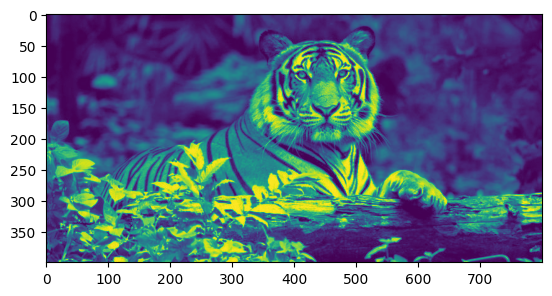

In [64]:
# Abrimos la imagen a color, por defecto con openCV es en bgr.
# imagen_bgr = cv.imread('/content/sample_data/Tigre.jpg', cv.IMREAD_GRAYSCALE)
# Abrimos la imagen a color, por defecto con openCV es en bgr.
imagen_bgr = cv.imread('CoordCrom_1.png', cv.IMREAD_GRAYSCALE)
h, w = imagen_bgr.shape
# Dimensión de la imagen
print(f'Tamaño imagen: {imagen_bgr.shape}') # Salida: (alto[px], ancho[px], canales).
plt.imshow(imagen_bgr)
plt.show()

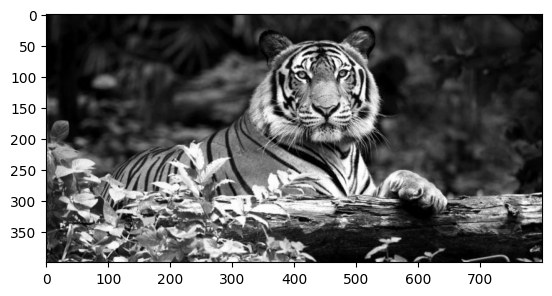

In [65]:
# Podemos pasarla a RGB
imagen_rgb = cv.cvtColor(imagen_bgr, cv.COLOR_BGR2RGB)
plt.imshow(imagen_rgb)
plt.show()

In [66]:
def create_gauss_filter(h, w, k_size, sigma):
    # Crear el filtro gaussiano en el dominio espacial
    gauss_filter = np.zeros((h, w))
    center_h = h // 2
    center_w = w // 2
    for i in range(h):
        for j in range(w):
            distance = np.sqrt((i - center_h) ** 2 + (j - center_w) ** 2)
            gauss_filter[i, j] = np.exp(-0.5 * (distance / sigma) ** 2)

    # Normalizar
    gauss_filter /= np.sum(gauss_filter)

    # FFT del filtro
    fft_gauss_filter = fft2(gauss_filter)

    return gauss_filter, fft_gauss_filter

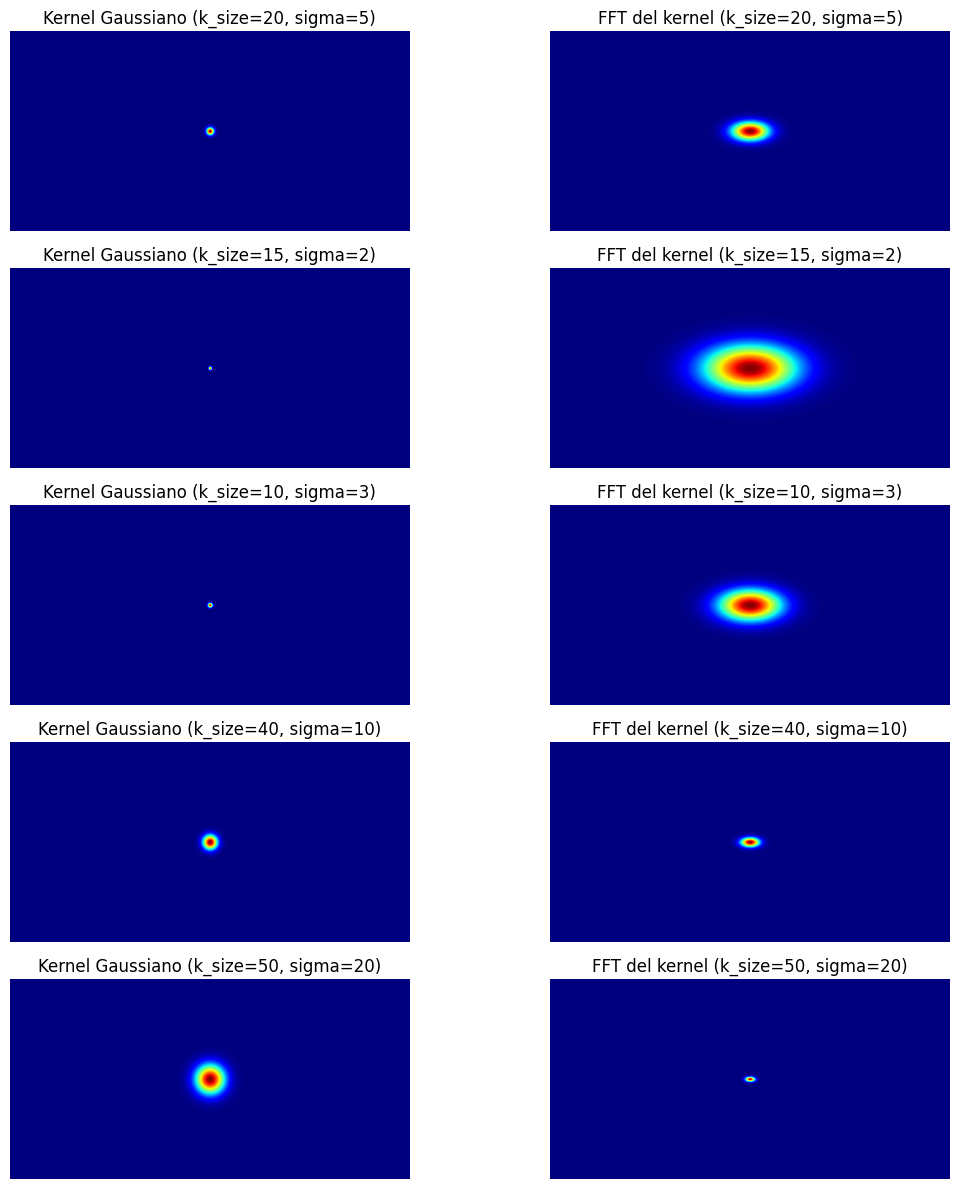

In [67]:
# Valores de k_size y sigma para las cuatro iteraciones
params = [(20, 5), (15, 2), (10, 3), (40, 10), (50, 20)]

plt.figure(figsize=(12, 12))

num_rows = len(params)  # Número de filas de subplots
num_cols = 2  # Número de columnas de subplots

for i, (k_size, sigma) in enumerate(params):
    # Crear el kernel gaussiano y su FFT
    kernel, kernel_tf = create_gauss_filter(h, w, k_size, sigma)

    # Graficar el kernel gaussiano
    plt.subplot(num_rows, num_cols, i*num_cols + 1)
    plt.axis('off')
    plt.title(f"Kernel Gaussiano (k_size={k_size}, sigma={sigma})")
    plt.imshow(kernel, cmap='jet')

    # Graficar la FFT del kernel
    plt.subplot(num_rows, num_cols, i*num_cols + 2)
    plt.axis('off')
    plt.title(f"FFT del kernel (k_size={k_size}, sigma={sigma})")
    tf_shifted = np.fft.fftshift(kernel_tf)
    plt.imshow(np.abs(tf_shifted), cmap='jet')

plt.tight_layout()
plt.show()

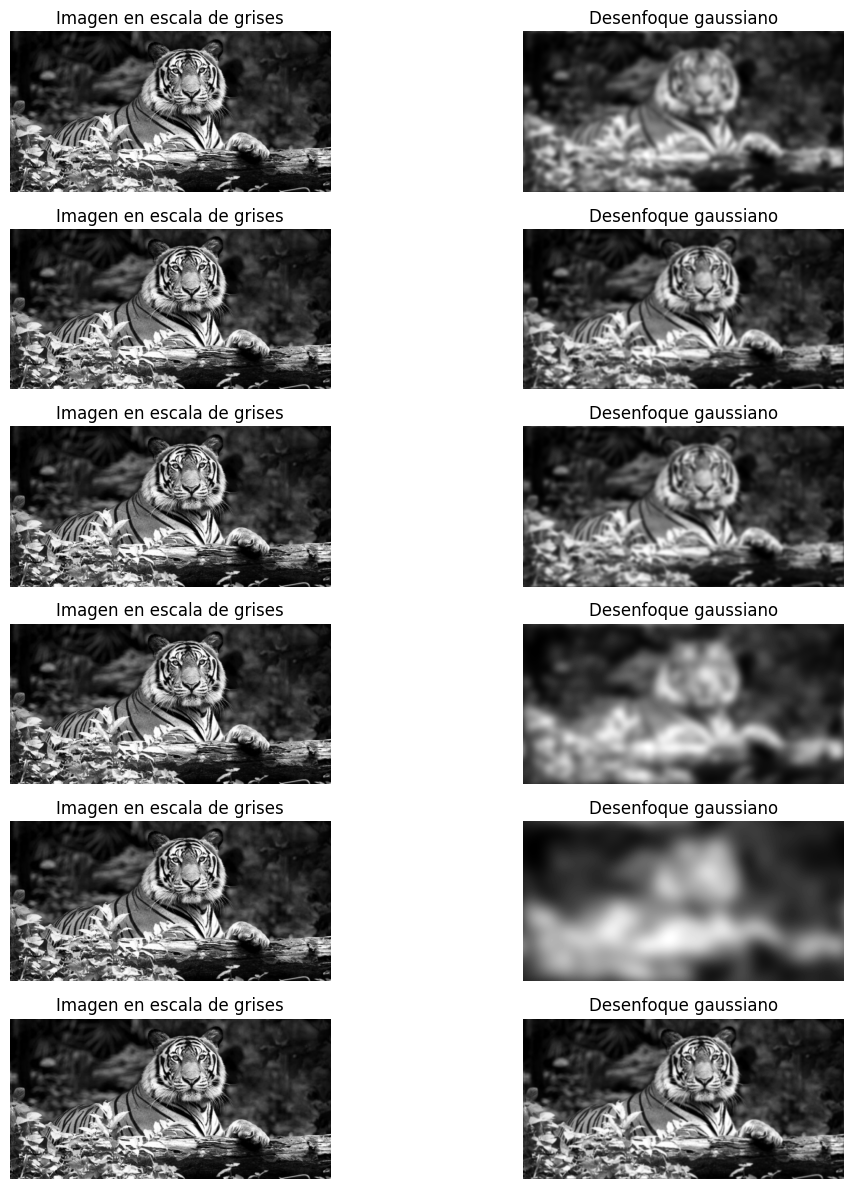

In [77]:
img_fft = np.fft.fft2(imagen_bgr)
# Valores de k_size y sigma para las cuatro iteraciones
params = [(20, 5), (15, 2), (10, 3), (40, 10), (50, 20), (10, 1)]

plt.figure(figsize=(12, 12))

num_rows = len(params)  # Número de filas de subplots
num_cols = 2  # Número de columnas de subplots

for i, (k_size, sigma) in enumerate(params):
    # Crear el kernel gaussiano y su FFT
    kernel, kernel_tf = create_gauss_filter(h, w, k_size, sigma)

    # Multiplicar img_fft por kernel_tf
    filtered = img_fft * kernel_tf

    # Calcular la imagen filtrada en el dominio espacial
    img_gauss = np.fft.ifftshift(np.real(np.fft.ifft2(filtered)))

    # Graficar la imagen original y la imagen filtrada
    plt.subplot(num_rows, num_cols, i * num_cols + 1)
    plt.axis('off')
    plt.imshow(imagen_rgb, cmap='gray')
    plt.title('Imagen en escala de grises')

    plt.subplot(num_rows, num_cols, i * num_cols + 2)
    plt.axis('off')
    plt.imshow(img_gauss, cmap='gray')
    plt.title('Desenfoque gaussiano')

plt.tight_layout()
plt.show()

Al aumentar el valor de sigma, se aumenta el suavizado aplicado a la imagen por lo que aporta al desenfoque. Lo mismo ocurre cuando aumenta el tamaño del kernel, aporta a un suavizado mas amplio lo que implica mayor desenfoque.

In [78]:
#Algorithm for image quality measure
def calc_FM(img):
    F = np.fft.fft2(img) # FFT de la imagen
    FCentro = np.fft.fftshift(F)
    AF = np.abs(FCentro) # Valor absoluto
    M = np.max(AF) # Valor máximo
    TH = np.count_nonzero(F > (M/1000))
    FM = TH/(img.shape[0]*img.shape[1]) # Medida de calidad
    return FM

In [79]:
def apply_filter(image, kernel_fft): # Aplicacion del filtro
    image_fft = np.fft.fft2(image)
    filtered_image_result = np.fft.ifft2(image_fft * kernel_fft)
    filtered_image_real = np.real(filtered_image_result)
    filtered_image_real_centered = np.fft.fftshift(filtered_image_real)
    filtered_image = filtered_image_real_centered.astype(np.uint8)
    return filtered_image

In [81]:
kernel, kernel_tf = create_gauss_filter(h, w, k_size=10, sigma=1) # Para valores de size y sigma que generan menor desenfoque
img_a = apply_filter(imagen_bgr, kernel_tf)
img_b = cv.filter2D(imagen_bgr, -1, kernel)
print(calc_FM(img_a), calc_FM(img_b)) # Comparacion de los resultados

0.016365625 0.016384375


In [82]:
#Absolute central moment
def calc_ACM(image):
    ACM = 0
    histogram = cv.calcHist([image], [0], None, [256], [0, 256])
    mean = np.mean(image)
    for i in range(len(histogram)):
        ACM += histogram[i] * np.abs(i - mean)
    return ACM/(imagen_bgr.shape[0]*imagen_bgr.shape[1])

In [84]:
kernel, kernel_tf = create_gauss_filter(h, w, k_size=10, sigma=1) # Para valores de size y sigma que generan menor desenfoque
img_a = apply_filter(imagen_bgr, kernel_tf)
img_b = cv.filter2D(imagen_bgr, -1, kernel)
print(calc_ACM(img_a), calc_ACM(img_b))

[53.90833125] [54.056975]


En ambos metodos obtenemos en las comparaciones valores próximos, los metodos son aplicados en distintos dominios (Espectral y espacial) pero la operación aplicada sobre la imagen es la misma.